<a href="https://colab.research.google.com/github/khchoi-physik/pbh_simulations/blob/main/nearest_neighbour_analysis_2d_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.special import erf
from sklearn.cluster import DBSCAN
import networkx as nx

import matplotlib.pyplot as plt
from matplotlib import cm

import copy
import time
import glob
import os
import gc

In [2]:
def grf_2d(mean, std_dev, pixel, amplitude, k_power):
    # Generate white noise in-place
    white_noise = np.random.normal(mean, std_dev, (pixel, pixel))

    # 2D Fast Fourier transform of the white noise
    fft_white_noise = np.fft.fft2(white_noise)
    del white_noise
    gc.collect()

    # Generating FFT momentum
    kx = np.fft.fftfreq(pixel) * pixel
    ky = np.fft.fftfreq(pixel) * pixel

    # Generating FFT momentum 2D array
    kx_grid, ky_grid = np.meshgrid(kx, ky)
    del kx, ky
    gc.collect()

    # Norm of k
    k_norm = np.sqrt(kx_grid**2 + ky_grid**2)
    k_norm[0, 0] = np.inf  # Regularize divergence at k=0
    del kx_grid, ky_grid
    gc.collect()

    # Power Spectrum P_k
    power_spectrum = amplitude * (((2 * np.pi / pixel) * k_norm) ** (-k_power))
    del k_norm  # Free memory
    gc.collect()

    # Multiply the power spectrum with the transformed white noise to get the realization of the spectrum
    fourier_amplitudes_sqrt = np.sqrt(power_spectrum, out=power_spectrum) * fft_white_noise
    del power_spectrum, fft_white_noise  # Free memory
    gc.collect()

    # Perform inverse Fourier transform to obtain the Gaussian random field in the spatial domain
    gaussian_random_field = np.fft.ifft2(fourier_amplitudes_sqrt).real
    del fourier_amplitudes_sqrt  # Free memory
    gc.collect()

    return gaussian_random_field


def gaussian_to_exp(x, lam):
    mu = np.mean(x)
    sigma = np.std(x)
    xu = 0.5 * (1 + erf((x - mu) / (np.sqrt(2) * sigma)))
    return -1/lam  * np.log(1 - xu)



def M(c2, c1, threshold):

    """
    First input : above-threshold overdensity
    Second input : above-threshold overdensity



    Define
    M[delta2, delta1]:=0.0311926 (4.25699 + delta1)^4.59551 delta2^4.12181
    If[delta1 <= 0.599,
    HeavisideTheta[delta2 - 0.002/(delta1 - 0.6) - 0.6], 1]

    delta2 (c2) is the amplitude of the above-threshold overdensity,
    delta1 (c1) is the amplitude of an overdensity in one of the
    nearest-neighbouring patches.

    For each nearest-neighbouring patch add deltaM to the mass
    of the "bare" above-threshold patch, M[0,delta2],
    to get the total mass in units of the horizon mass.

    """


    """
    linearly re-scale the amplitudes delta1 and delta2 such that
    0.6 corresponds to the utilised threshold value (at a given rareness).
    """

    c1 = 0.6 * c1 / threshold
    c2 = 0.6 * c2 / threshold


    if c1 <= 0.599:
        return 0.0311926 * (4.25699 + c1)**4.59551 *  c2**4.12181 * np.heaviside(c2 - 0.002/(c1-0.6) - 0.6, 0)

    else:
        return 0.0311926 * (4.25699 + c1)**4.59551 *  c2**4.12181


def dM(c2, c1, threshold):

    """
    Approximate mass increase for each nearest-neighbouring overdensity.
    (Through the "If" command, I have set it equal to zero whenever the
    threshold is not met.)

    deltaM[delta1,delta2]:=If[M[0, delta2] == 0, 0, M[delta1, delta2]-M[0, delta2]]
    """

    mass = M(c2,c1,threshold)

    if mass == 0:
        return 0
    else:
        return mass - M(c2,0,threshold)


def total_M(M_list):
    return np.sum(M_list)
    """
    M_total = Sum_{j in cluster} M[0, delta2_j]
    + Sum_{i=1}^{8} deltaM[delta1_i,delta2_j],
    wherein the second sum runs over all eight nearest neighbours.
    The indices j represents here the threshold exceeding events.
    """

## Please then make a series of plots for each case (exponential and
## Gaußian random fields with n = 0, 1, 2, 3 each), wherein you
## compare the initial mass sepctrum (M0) with M_total

In [3]:

# from google.colab import drive
# drive.mount('/content/gdrive')

# folder_path = '/content/gdrive/My Drive/0 Article/PBH/Proof_of_concepts/data/'
# main_path = folder_path + f'k_{k_power}'
# os.chdir(main_path)

In [8]:
k_power = 2
pixel = 2**11

exprf = gaussian_to_exp( grf_2d(mean= 0, std_dev = 1, pixel= pixel, amplitude = 1, k_power=k_power), 1)
print(exprf.shape)

(2048, 2048)


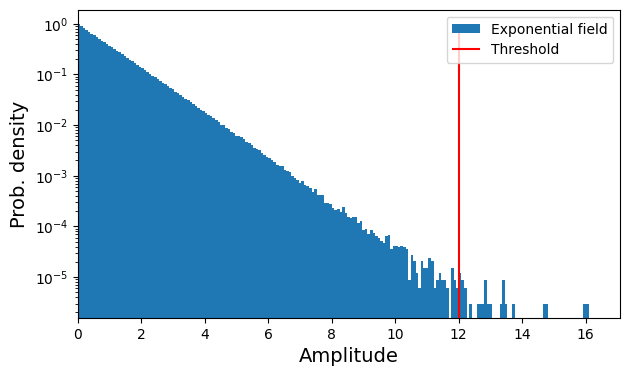

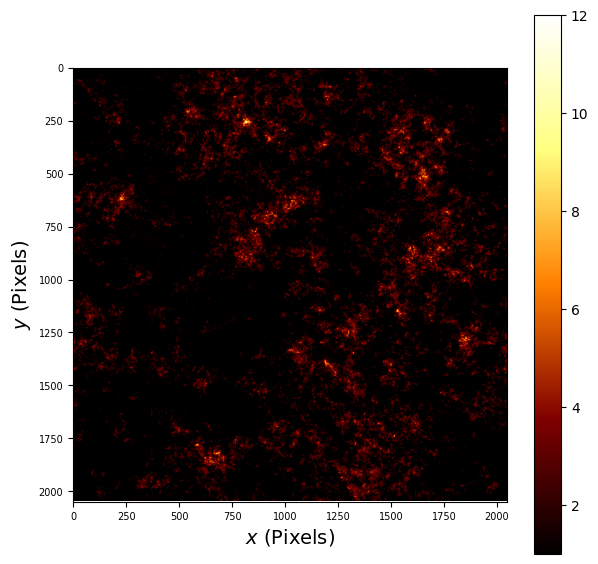

In [9]:

# Threshold for defining rare events

threshold = 12
#threshold = 11

# Histogram of the exponential random field

plt.figure( figsize = (7,4))
plt.hist(exprf.flatten(), bins=201, density=True, label='Exponential field');
plt.yscale('log')
plt.xlim(0,exprf.max()+1)
plt.xlabel('Amplitude', fontsize=14)
plt.ylabel('Prob. density', fontsize=14)
plt.vlines(threshold,0,1, color='r', label='Threshold')
plt.legend()
plt.savefig('Prob_dens.pdf', bbox_inches='tight', dpi=300)
plt.show()

psize = 7

# An intuitive realization of the random field

plt.figure( figsize = (psize,psize))
plt.imshow(exprf, cmap='afmhot')
plt.xlabel(f'$x$ (Pixels)',fontsize=psize*2)
plt.ylabel(f'$y$ (Pixels)',fontsize=psize*2)
plt.xticks(fontsize=psize)
plt.yticks(fontsize=psize)
plt.colorbar()
plt.clim(1,threshold)
plt.savefig('Field.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [10]:
# @title Clustering analysis


"""
Clustering algorithm: DBSCAN
https://cdn.aaai.org/KDD/1996/KDD96-037.pdf

eps : The maximum distance between two samples for one to be considered
as in the neighborhood of the other.

min_samples : The number of samples (or total weight) in a neighborhood
for a point to be considered as a core point. This includes the point itself.
"""

eps = 100
min_samples = 2


# Return an array indicating the coordinates
# where exprf > threshold
pos = np.argwhere(exprf > threshold)
print("\n # of threshold exceeding events:", pos.shape)

"""
WARNING,
"""


# Run DBSCAN
clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(pos)

# Export labels of clustering analysis
labels = clustering.labels_
print("\n Cluster they belong to: ", labels)

# Number of clusters
num_clt = len(set(labels))
print("\n # of cluster incl. anomoly: ", num_clt)

# Initialize empty dictionary
clt_pos_dict = {}

# Iterate over all clustes
for ii in set(labels):

    # Find the index of the cluster
    clt_idx = np.where(labels == ii)
    # Find the coordinates of the cluster using the index
    clt_pos = pos[clt_idx]
    # Append the coordinates into the dictionary
    clt_pos_dict[ii] = clt_pos

# Color scheme defined bby the total # of clusters
cmap = cm.get_cmap('rainbow', num_clt)


 # of threshold exceeding events: (28, 2)

 Cluster they belong to:  [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  1  1  1 -1 -1  2  2  2
  2 -1  3  3]

 # of cluster incl. anomoly:  5


<ipython-input-10-ed5212cb8665>:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow', num_clt)


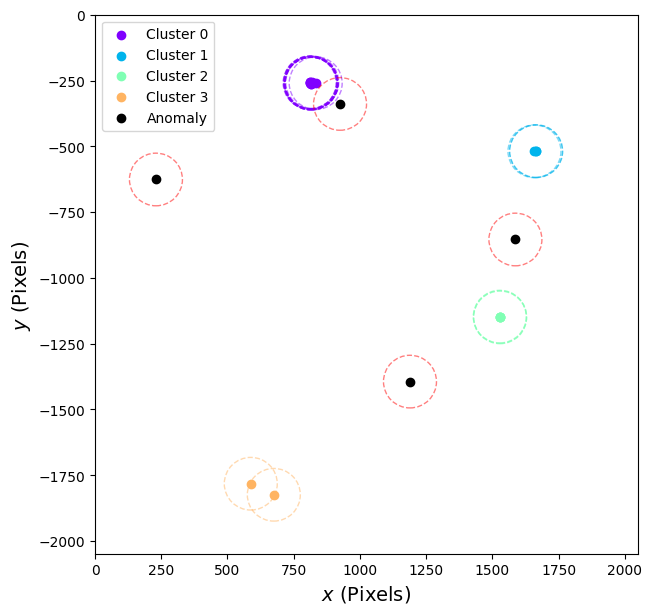

In [11]:
# @title Intuitive visualization of clustering

plt.figure( figsize = (psize,psize))

for ii in set(labels):
    clt_idx = np.where(labels == ii)
    clt_pos = pos[clt_idx]
    color = cmap(ii % num_clt)

    if ii == -1:
        plt.scatter( clt_pos[:,1], -clt_pos[:,0] , c='k', label='Anomaly')
    else:
        plt.scatter( clt_pos[:,1], -clt_pos[:,0] , color = color, label=f'Cluster {ii}')

    for p in clt_pos:
        circle = plt.Circle((p[1], -p[0]), eps, color = color, fill=False, linestyle='--', alpha=0.5)  # You can adjust the circle properties here
        plt.gca().add_artist(circle)


plt.xlabel(f'$x$ (Pixels)', fontsize=14)
plt.ylabel(f'$y$ (Pixels) ', fontsize=14)
plt.xlim(0,exprf.shape[0])
plt.ylim(-exprf.shape[1],0)
plt.legend()
# plt.savefig('Cluster.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [12]:
l = 1 ## box size = 2L+1

"""
Structure of the dictoinary:
coordinates[i][j] referes to the coordinate of the i-th cluster
and the j-th threshold exceeding events.
"""

# Generate offsets for the 3x3 box
offsets = np.array( [(i,j) for i in range(-l,l+1) for j in range(-l,l+1)])
# Generate offsets for the 3x3 box exlcuding center
offsets_no_center = np.array( [(i,j) for i in range(-l,l+1) for j in range(-l,l+1) if not (i==0 and j==0)] )

# Initialize empty dictionary to store the all coordinates of the box
coordinates = {}
coordinates_nn = {}

# Iterate over each cluster in labels, exlcuding `-1`
for ii in set(labels) - {-1}:

    # Initialize empty dictionaries to store threshold exceedence events within
    # each cluster
    coordinates[ii] = {}
    coordinates_nn[ii] = {}

    for jj in range(len(clt_pos_dict[ii])):
        coordinates[ii][jj] = clt_pos_dict[ii][jj] + offsets
        coordinates_nn[ii][f'{clt_pos_dict[ii][jj]}']  = clt_pos_dict[ii][jj] + offsets_no_center
        # uni_coordinates[ii][jj] = []

    # # Concatenate lists of arrays into a single array
    # coordinates[ii] = np.concatenate(coordinates[ii])
    # # Remove duplications
    # uni_coordinates[ii] = np.unique(coordinates[ii], axis=0)

# Create a copy of the same dictionary
coordinates_nn2 = copy.deepcopy(coordinates_nn)

In [13]:
# # Crosscheck if the dictionary after deepcopy is the same
# for ii in set(labels) - {-1}:
#     for jj in range(len(clt_pos_dict[ii])):
#      print(coordinates_nn2[ii][f'{clt_pos_dict[ii][jj]}'] == coordinates_nn2[ii][f'{clt_pos_dict[ii][jj]}'])

In [14]:
# @title Merging neighbourhoods

# Intitialize dictionary for the coordiantes of the threshold exceeding events
coor_list = {}
# Initialize dictinoary for threshold exceeding events after nearest
# neighbourhood clustering algorithm
clt_pos_dict_merged = {}


"""
STEP 1:
Re-ordering the coordinates of the threshold exceeding events
from the strongest to the weakest. The anomolys are not included.
"""
for ii in set(labels) - {-1}:
    # Initialize empty list
    coor_list[ii] = []

    # x coordinates of the threshold exceeding events
    x_coor = clt_pos_dict[ii][:,0]
    # y coordinates of the threshold exceeding events
    y_coor = clt_pos_dict[ii][:,1]

    # Construct arrays of the formation [coordinates, amplitude]
    coor_list[ii] = np.column_stack( (clt_pos_dict[ii], exprf[x_coor, y_coor]) )
    # Sort the array with largest amplitude as the first entity
    coor_list[ii] = sorted(coor_list[ii], key=lambda x: x[2], reverse=True)
    # Convert the coordiantes as integer type (as they are supposed to be)
    coor_list[ii] = np.array(coor_list[ii])[:,:2].astype(int)


"""
STEP 2: Merging the primary and secondary neighborhoods

Definitions:
- Primary threshold exceedence : The threshold exceedence under consderation.
- Primary neighborhood : The nearest neighbors of the primary threshold exceedence.

- Secondary threshold exceedence : The threshold exceedence that is in the primary neighborhood.
- Secondary neighborhood : The nearest neighbors of the secondary threshold exceedence.

- Threshold exceedence set: The set of all threshold exceedence within the clsuter.
- Intersection set: The set of secondary threshold exceedence. Initialized as empty list.

"""
for ii in set(labels) - {-1}:
    # Initialize list for intersected set
    inter_list = []
    # Initalize list for storing the threshold exceeding events
    clt_pos_dict_merged[ii] = []

    # The set of threshold exceeding events
    # Converted to an unique set of tuple
    th_set = set(map(tuple, coor_list[ii]))
    print("Set of threshold exceedence :", th_set)

    #
    for coor in  coor_list[ii]:
        # Coordinates of the primary threshold exceedence
        print("Threshold exceedence coordinate:", coor)

         # Skip if the primary threshold exceedence is in the intersection set
        if inter_list and any(np.any(np.all(coor == arr, axis=1)) for arr in inter_list if arr.size > 0):
            print('Already excluded \n')
            continue
        else:
            clt_pos_dict_merged[ii].append(coor)

        # The serach program will now repeat until explored all the secondary
        # threshold exceedence events
        repeat = True
        while repeat:

            # Discard the secondary threshold exceedence from it's set
            # if it is still in the set.
            if tuple(coor) in th_set:
                th_set.remove(tuple(coor))

            # Define the set of unique nearest neighbors
            # ( primary + secondary neighborhood )
            nn_set = set(map(tuple, coordinates_nn[ii][f'{coor}']))
            print("# of neighbours :", len(nn_set) )

            # Obtain the intersection set from the intersection between
            # the set of threshold exceedence and the set of nearest neighbors
            interset = th_set.intersection(nn_set)
            print("Set of intersection:", interset)

            # Discard intersections set from the threshold exceedence canidates
            # This removes the secondary exceedences from the
            # set of threshold exceedence
            th_set -= interset
            print("New set of threshold exceedence :", th_set)

            # Convert the set of intersection into a numpy array
            interset = np.array(list(interset)).astype(int)
            # Record the intersection set to the collection of intersection
            inter_list.append(interset)

            # Merging all the secondary neighborhoods with primary neighborhoods
            if len(interset) > 0:

                # Merging all the secondary neighborhoods with primary neighborhoods
                for int_coor in interset:
                    coordinates_nn[ii][f'{coor}'] = np.vstack( ( coordinates_nn[ii][f'{coor}'], coordinates_nn[ii][f'{int_coor}']) )
                    print(f"Merging neighbourhood {int_coor} with {coor}. # of neighbours = ", len(coordinates_nn[ii][f'{coor}']))
                    del coordinates_nn[ii][f'{int_coor}']
                    #print(f"Delete neighbourhood {int_coor} ")

                # Discard duplicated neighborhood
                coordinates_nn[ii][f'{coor}'] = np.unique( coordinates_nn[ii][f'{coor}'], axis= 0)
                # Discard primary exceedence
                coordinates_nn[ii][f'{coor}'] = coordinates_nn[ii][f'{coor}'][~np.all(coordinates_nn[ii][f'{coor}'] == coor , axis=1)]
                # Repeat to explore consective neighborhood
                repeat = True

            else:
                repeat = False

    print("# of Finial neighbourhood = ", coordinates_nn[ii], "\n")

Set of threshold exceedence : {(259, 817), (261, 814), (260, 817), (260, 833), (259, 810), (262, 816), (257, 820), (262, 815), (259, 816), (260, 816), (259, 812), (256, 813), (257, 813), (261, 815), (260, 818)}
Threshold exceedence coordinate: [259 817]
# of neighbours : 8
Set of intersection: {(259, 816), (260, 816), (260, 817), (260, 818)}
New set of threshold exceedence : {(261, 814), (260, 833), (259, 810), (262, 816), (257, 820), (262, 815), (259, 812), (256, 813), (257, 813), (261, 815)}
Merging neighbourhood [259 816] with [259 817]. # of neighbours =  16
Merging neighbourhood [260 816] with [259 817]. # of neighbours =  24
Merging neighbourhood [260 817] with [259 817]. # of neighbours =  32
Merging neighbourhood [260 818] with [259 817]. # of neighbours =  40
# of neighbours : 18
Set of intersection: {(261, 815)}
New set of threshold exceedence : {(261, 814), (260, 833), (259, 810), (262, 816), (257, 820), (262, 815), (259, 812), (256, 813), (257, 813)}
Merging neighbourhood [

[259 817] 16.0 (31,)
[260 833] 13.4 (8,)
[257 813] 13.0 (11,)
[259 810] 12.9 (8,)
[259 812] 12.9 (8,)
[257 820] 12.1 (8,)
Cluster0: total mass list [119.3521133181219, 20.60634771800705, 30.433028645435147, 24.734743347270445, 28.36159819136697, 19.48531253104349]
Cluster0: bare mass list [9.654717571675043, 4.724115468749608, 4.1270276130097505, 3.9554703157759055, 3.947969347200587, 3.0732107896024257]
Cluster0: total mass list 242.97314375124498
Cluster0: bare_mass list 29.48251110601332
[ 518 1665] 12.6 (11,)
[ 519 1659] 12.4 (8,)
Cluster1: total mass list [12.206067391323218, 12.80193542569641]
Cluster1: bare mass list [3.6732715370991778, 3.333923259617905]
Cluster1: total mass list 25.00800281701963
Cluster1: bare_mass list 7.007194796717083
[1149 1529] 16.1 (19,)
Cluster2: total mass list [66.97280595885266]
Cluster2: bare mass list [9.906901835043215]
Cluster2: total mass list 66.97280595885266
Cluster2: bare_mass list 9.906901835043215
[1782  588] 12.7 (8,)
[1824  675] 12.2 (

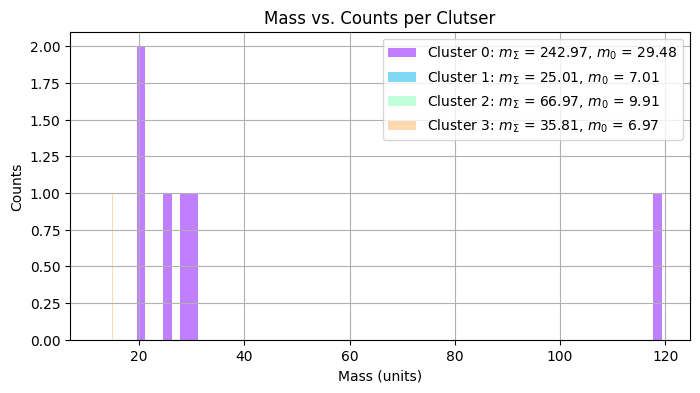

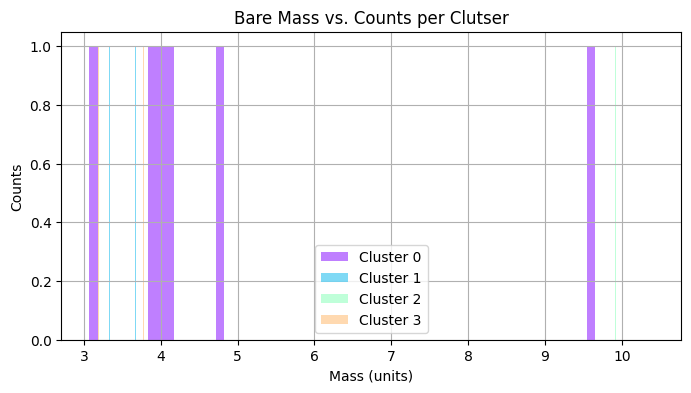

In [15]:
"""
Define indices and variables:

i = Cluster
j = Threshold Exceedence
k = Nearest Neighbours


d2 = delta2 = Threshold exceedence amplitude
d1 = delta1 = Nearest neighbour amplitude
"""


# Mask for filtering
def filtering(x,y,pixel):
    domain_mask = (x >= 0) & (x < pixel) & (y >= 0) & (y < pixel)
    return x[domain_mask], y[domain_mask]


# Intialize empty list - vector
cluster_mass_i = {}
bare_mass_i = {}

# Initialize empty dictionary - rank 2 tensor
# Total mass for all threshold exceedence [j] in each clsuter [i]
# Total mass for all threshold exceedence [j] in each cluster [i]
cluster_mass_list_ij, bare_mass_list_ij = {} , {}

# for ii in set(labels) -{-1, 1, 2,3,4}:
for ii in set(labels) -{-1}:
    #Intiialize empty list for each cluster for storing m_ijk
    cluster_mass_list_ij[ii], bare_mass_list_ij[ii] = [] , []
    #Intiialize empty list for each cluster M_ij
    cluster_mass_i[ii], bare_mass_i[ii] = [], []

    for jj in range( len(clt_pos_dict_merged[ii]) ):

        ## position of the j-th threshold exceedence within the j-th cluster - rank 2 tensor
        pos_jj = clt_pos_dict_merged[ii][jj]
        ## amplitude of the j-th threshold exceedence within the i-th cluster - rank 2 tensor
        d2_ij = exprf[pos_jj[0], pos_jj[1] ]

        # Coorindates (x) of the merged neighborhood
        x_ijk = coordinates_nn[ii][f'{pos_jj}'][:,0]
        # Coorindates (y) of the merged neighborhood
        y_ijk = coordinates_nn[ii][f'{pos_jj}'][:,1]

        # If the threshoold is at the edge of the entire simulation, discard
        # neighborhoods that are outside the simulation.
        if (pos_jj[0] == 0 or pos_jj[1]== 0 or pos_jj[0] == pixel -1 or pos_jj[1] == pixel -1 ):
            x_ijk, y_ijk = filtering(x_ijk, y_ijk, pixel)

        # List of amplitudes of the merged neighborhood
        d1_ijk = exprf[x_ijk, y_ijk]

        print(pos_jj, np.round(d2_ij,1), d1_ijk.shape)
        # Initialize empty list - rank 3 tensor
        # delta M, additional mass due to nearest neighbour
        dM_ijk = []

        """
        Define
        M[delta2, delta1]:=0.0311926 (4.25699 + delta1)^4.59551 delta2^4.12181
        If[delta1 <= 0.599,
        HeavisideTheta[delta2 - 0.002/(delta1 - 0.6) - 0.6], 1]

        delta2 (d2) is the amplitude of the above-threshold overdensity,
        delta1 (d1) is the amplitude of an overdensity in one of the
        nearest-neighbouring patches.
        """

        # Calculate additional mass for each nearest neighbour
        for d1 in d1_ijk:
            dM_ijk.append( dM(d1, d2_ij, threshold) )
            # print("Amplitude =", d1, "Neighbor =", dM(d1, d2_ij, threshold) )

        # Total mass for a given threshold exceedence in a given cluster
        # Sum over [k] and the threshold exceedenece
        def nn_sum(dM_list):
            return np.sum(dM_ijk) + M(d2_ij, 0, threshold)
        # print("neighborhood = ", np.sum(dM_ijk) , "bare =",  M(d2_ij, 0, threshold))

        # Total mass for a given threshold exceedence in a given cluster
        cluster_mass_list_ij[ii].append(nn_sum(dM_ijk))
        # Bare mass for a given threshold exceedence in a given cluster
        bare_mass_list_ij[ii].append(M(d2_ij, 0, threshold))

    cluster_mass_i[ii] = np.sum(cluster_mass_list_ij[ii])
    bare_mass_i[ii] = np.sum(bare_mass_list_ij[ii])


    print(f"Cluster{ii}: total mass list", cluster_mass_list_ij[ii])
    print(f"Cluster{ii}: bare mass list", bare_mass_list_ij[ii])

    print(f"Cluster{ii}: total mass list", cluster_mass_i[ii] )
    print(f"Cluster{ii}: bare_mass list", bare_mass_i[ii] )

plt.figure( figsize = (8,4))

for ii in set(labels)-{-1}:
    color = cmap(ii % num_clt)
    plt.hist(cluster_mass_list_ij[ii][:], bins=60, label=f'Cluster {ii}: $m_\Sigma$ = {np.round(cluster_mass_i[ii],2)}, $m_0$ = {np.round(bare_mass_i[ii],2)}' , alpha =0.5, color=color)

plt.legend()
plt.title("Mass vs. Counts per Clutser")
plt.xlabel("Mass (units)")
plt.ylabel("Counts")
plt.grid()
plt.show()

plt.figure( figsize = (8,4))
for ii in set(labels)-{-1}:
    color = cmap(ii % num_clt)
    plt.hist(bare_mass_list_ij[ii][:], bins=60,  label=f'Cluster {ii}', alpha =0.5, color=color)
plt.title("Bare Mass vs. Counts per Clutser")
plt.xlabel("Mass (units)")
plt.ylabel("Counts")
plt.grid()
plt.legend()
plt.show()

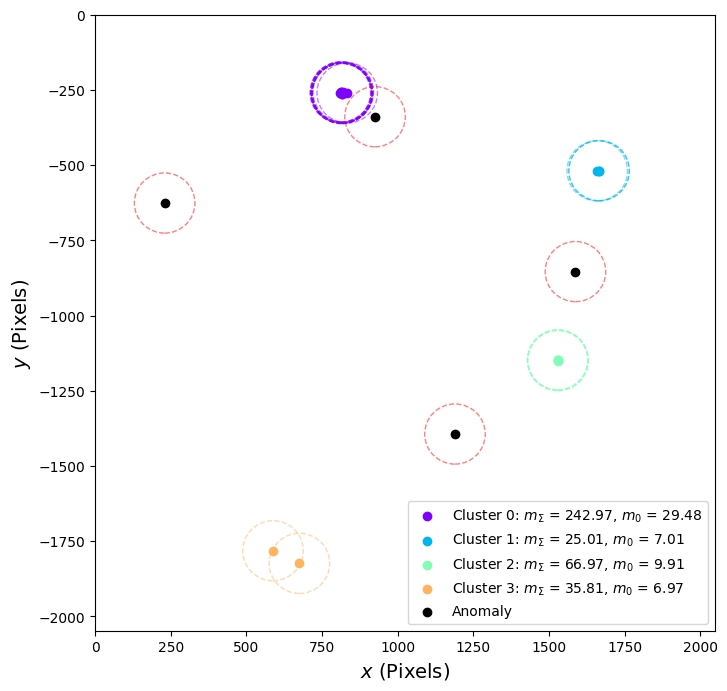

In [16]:
plt.figure( figsize = (8,8))

for ii in set(labels):
    clt_idx = np.where(labels == ii)
    clt_pos = pos[clt_idx]
    color = cmap(ii % num_clt)

    if ii == -1:
        plt.scatter( clt_pos[:,1], -clt_pos[:,0] , c='k', label='Anomaly')
    else:
        plt.scatter( clt_pos[:,1], -clt_pos[:,0] , color = color, label=f'Cluster {ii}: $m_\Sigma$ = {np.round(cluster_mass_i[ii],2)}, $m_0$ = {np.round(bare_mass_i[ii],2)}' )

    for p in clt_pos:
        circle = plt.Circle((p[1], -p[0]), eps, color = color, fill=False, linestyle='--', alpha=0.5)  # You can adjust the circle properties here
        plt.gca().add_artist(circle)


plt.xlabel(f'$x$ (Pixels)', fontsize=14)
plt.ylabel(f'$y$ (Pixels) ', fontsize=14)
plt.xlim(0,exprf.shape[0])
plt.ylim(-exprf.shape[1],0)
plt.legend()
plt.savefig('Cluster.pdf', bbox_inches='tight', dpi=300)
plt.show()

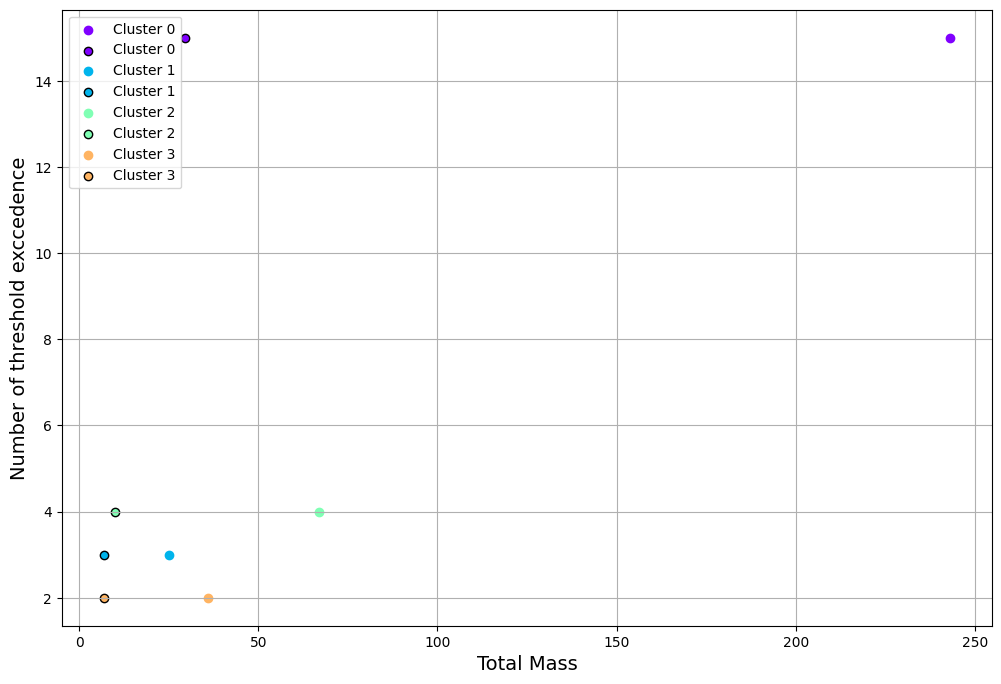

In [17]:
plt.figure( figsize = (12,8))
for ii in set(labels) - {-1}:
    color = cmap(ii % num_clt)
    plt.scatter( cluster_mass_i[ii], clt_pos_dict[ii].shape[0], label=f'Cluster {ii}',  color = color)
    plt.scatter( bare_mass_i[ii], clt_pos_dict[ii].shape[0], label=f'Cluster {ii}',  color = color, edgecolors='black')
#cluster_mass_list_ij
plt.legend()
plt.xlabel('Total Mass', fontsize=14)
plt.ylabel('Number of threshold exccedence', fontsize=14)
plt.grid()
plt.savefig('Mass_vs_Thres_ex.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [18]:
# amplitude_list = {}

# for ii in set(labels) - {-1}:
#     amplitude_list[ii] = []
#     amplitude_list[ii] = exprf[coordinates[ii][:,0], coordinates[ii][:,1]]


# plt.figure( figsize = (12,8))
# for ii in set(labels) - {-1}:

#     color = cmap(ii % num_clt)
#     plt.hist(amplitude_list[ii], bins=50, label=f'Cluster {ii}', color = color, alpha=0.3)

# plt.legend()
# plt.xlabel('Ampltiudes', fontsize=14)
# plt.ylabel('Population', fontsize=14)
# plt.grid()
# plt.savefig('Amp_hist.pdf', bbox_inches='tight', dpi=300)
# plt.show()

In [19]:
# plt.figure( figsize = (12,8))
# for ii in set(labels) - {-1}:
#     color = cmap(ii % num_clt)
#     plt.hist(amplitude_list[ii], bins=101,  label=f'Cluster {ii}', color = color, density=True,alpha =0.3)

# plt.hist(exprf.flatten(), bins=101,  label='Exponential Field', color = 'k', density=True, alpha=0.5)
# plt.legend()
# plt.xlabel('Ampltiudes', fontsize=14)
# plt.ylabel('Prob. density', fontsize=14)
# plt.xlim(0,exprf.max()+1)
# plt.grid()
# plt.savefig('Amp_hist_with_exprf.pdf', bbox_inches='tight', dpi=300)
# plt.show()

Cluster 0


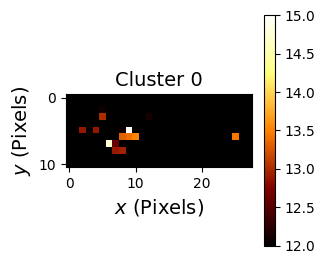

Cluster 1


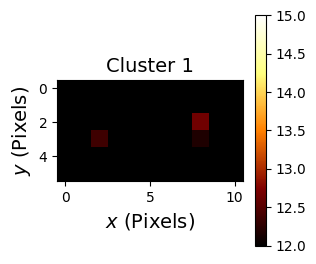

Cluster 2


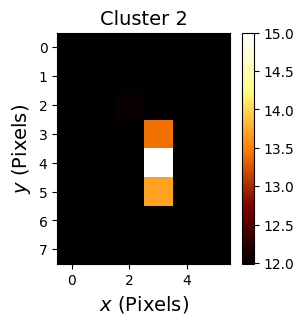

Cluster 3


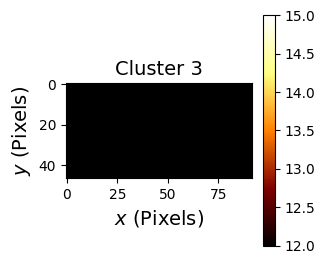

In [28]:
for ii in set(labels) - {-1}:

    coors = np.vstack( [ data for data in coordinates_nn[ii].values() ] )
    print(f'Cluster {ii}')

    l0 = 1

    xmin = coors[:,0].min() - l0
    xmax = coors[:,0].max() + l0 +1
    ymin = coors[:,1].min() - l0
    ymax = coors[:,1].max() + l0 +1

    subexprf = exprf[xmin:xmax , ymin:ymax]

    plt.figure(figsize = (3,3))

    plt.imshow(subexprf, cmap='afmhot')
    plt.title(f'Cluster {ii}', fontsize=14)
    plt.xlabel(f'$x$ (Pixels)',fontsize=14)
    plt.ylabel(f'$y$ (Pixels)',fontsize=14)
    plt.colorbar()
    plt.clim(threshold-0.01,threshold+3)
    plt.savefig(f'SmallCluster_{ii}.pdf', bbox_inches='tight', dpi=300)
    plt.show()

[259 817]
(31, 2)
[260 833]
(8, 2)
[257 813]
(11, 2)
[259 810]
(8, 2)
[259 812]
(8, 2)
[257 820]
(8, 2)


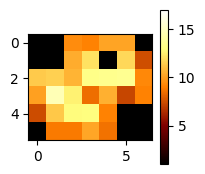

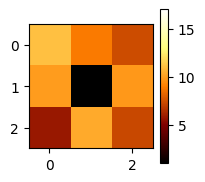

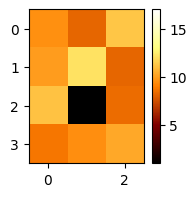

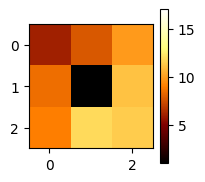

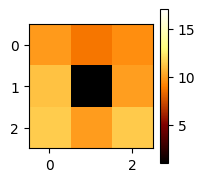

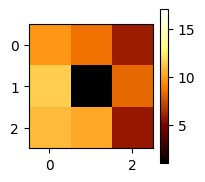

[ 518 1665]
(11, 2)
[ 519 1659]
(8, 2)


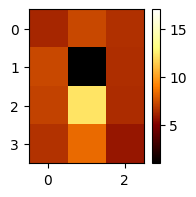

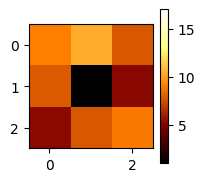

[1149 1529]
(19, 2)


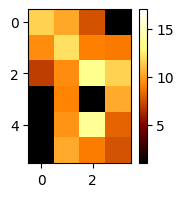

[1782  588]
(8, 2)
[1824  675]
(8, 2)


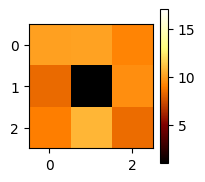

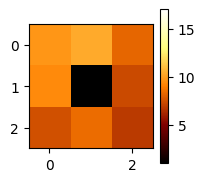

In [27]:
for cc in set(labels) -{-1}:

    for posit in clt_pos_dict_merged[cc]:
        print(posit)
        print(coordinates_nn[cc][f'{posit}'].shape)

    for posit in clt_pos_dict_merged[cc]:
        xs = coordinates_nn[cc][f'{posit}'][:,0]
        ys = coordinates_nn[cc][f'{posit}'][:,1]
        non_zero_mask = (xs != 0) & (ys != 0)
        exprf_filtered = np.zeros_like(exprf)  # Create a copy of exprf initialized with zeros
        exprf_filtered[xs[non_zero_mask], ys[non_zero_mask]] = exprf[xs[non_zero_mask], ys[non_zero_mask]]

        xmin = xs.min()
        xmax = xs.max() +1
        ymin = ys.min()
        ymax = ys.max() +1

        exprf_filtered = exprf_filtered[xmin:xmax , ymin:ymax]

        plt.figure(figsize = (2,2))
        plt.imshow(exprf_filtered, cmap='afmhot')
        plt.clim(1,threshold+5)
        plt.colorbar()

        plt.show()

In [29]:
pos_amp_list = {}
coor_list = {}

for ii in set(labels) - {-1}:
    pos_amp_list[ii] = []
    coor_list[ii] = []

    x_coor = clt_pos_dict[ii][:,0]
    y_coor = clt_pos_dict[ii][:,1]

    pos_amp_list[ii] = np.column_stack( (clt_pos_dict[ii], exprf[x_coor, y_coor]) )
    pos_amp_list[ii] = sorted(pos_amp_list[ii], key=lambda x: x[2], reverse=True)

    coor_list[ii] = np.array(pos_amp_list[ii])[:,:2].astype(int)